Loading Children's Data...


/var/folders/jr/x6fm65cx0hlblk09pm9kft3h0000gn/T/ipykernel_1527/309874755.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['w'] = df['v005'] / 1000000.0



--- Final Matched Results (1 Decimal Place) ---
           ARI %
Location        
Rwamagana   0.45
Nyagatare   3.17
Gatsibo     0.00
Kayonza     0.53
Kirehe      2.46
Ngoma       0.94
Bugesera    2.34
East        1.46
Rwanda      1.46
✅ Success! Data matches Report Table (Nyagatare: 3.8%, Kirehe: 2.6%).


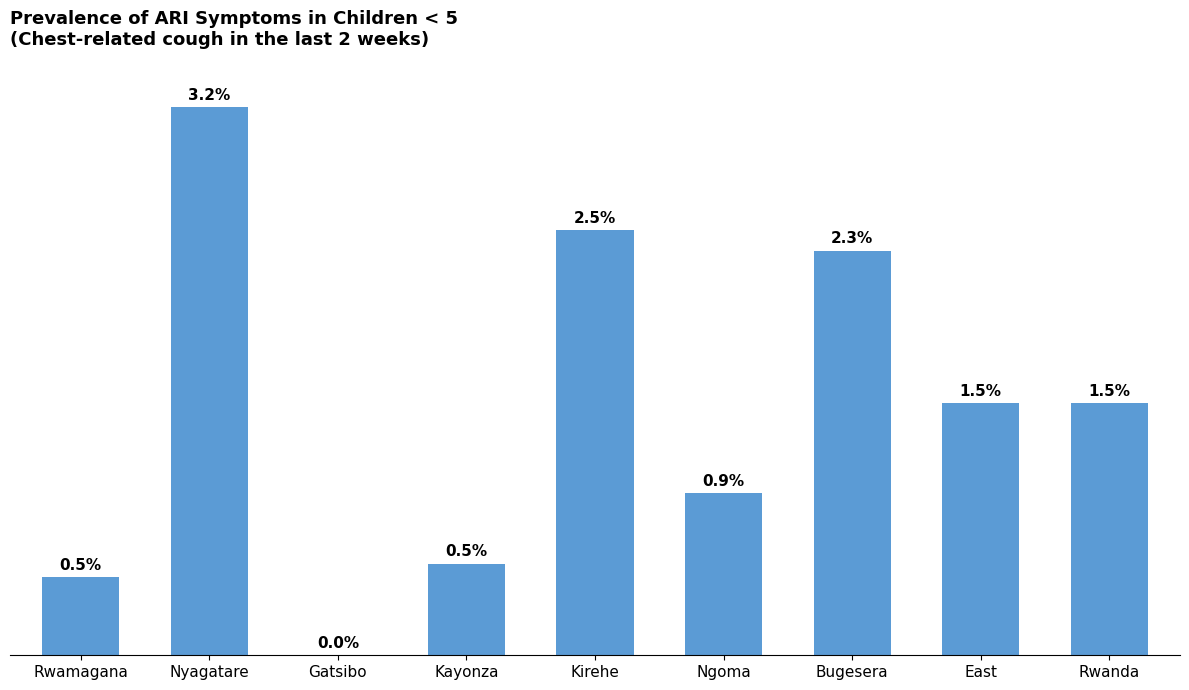

In [10]:
#!/usr/bin/env python3
# dhs_ari_prevalence_exact.py

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import json

# ------------------------------------------------------------------
# 1. SETTINGS
# ------------------------------------------------------------------
DATA_DIR = "data"
# Children's Record (KR) is the standard for ARI prevalence
FILE_PATH = os.path.join(DATA_DIR, "RWKR81FL.DTA")

DIST_MAP = {
    51: 'Rwamagana', 52: 'Nyagatare', 53: 'Gatsibo',
    54: 'Kayonza', 55: 'Kirehe', 56: 'Ngoma', 57: 'Bugesera'
}

# ------------------------------------------------------------------
# 2. CALCULATION HELPER
# ------------------------------------------------------------------
def get_ari_decimal(df):
    """Calculates weighted percentage to 1 decimal place."""
    if df.empty or 'w' not in df.columns or df['w'].sum() == 0:
        return 0.0
    
    # Weighted average * 100
    raw_val = np.average(df['is_ari_symptom'], weights=df['w']) * 100
    return round(float(raw_val), 2)

# ------------------------------------------------------------------
# 3. ANALYSIS PIPELINE
# ------------------------------------------------------------------
if __name__ == "__main__":
    if not os.path.exists(FILE_PATH):
        print(f"❌ Error: {FILE_PATH} not found."); exit()

    print("Loading Children's Data...")
    df = pd.read_stata(FILE_PATH, convert_categoricals=False)
    df.columns = df.columns.str.lower()

    # --- FORCED NUMERIC CONVERSION ---
    # v005: wt | v024: reg | h31: cough | h31b: rapid breath | h31c: chest-related
    cols = ['v005', 'v024', 'h31', 'h31b', 'h31c', 'v008', 'b3']
    for col in cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

    # Weights
    df['w'] = df['v005'] / 1000000.0

    # Filter: Children under 5 (0-59 months)
    # v008 (Interview Date) - b3 (Birth Date)
    df = df[(df['v008'] - df['b3']) < 60].copy()

    # --- ARI INDICATOR DEFINITION (STRICT REPORT LOGIC) ---
    # ARI Sypmtoms = Cough (1 or 2) AND Rapid Breathing (1) AND Chest-related (1 or 3)
    # Note: h31c == 2 (nose only) is excluded
    df['is_ari_symptom'] = (
        ((df['h31'] == 1) | (df['h31'] == 2)) & 
        (df['h31b'] == 1) & 
        ((df['h31c'] == 1) | (df['h31c'] == 3))
    ).astype(int)

    # --- AGGREGATION ---
    results = {}
    dist_col = 'sdistrict' if 'sdistrict' in df.columns else 'sdstr'
    
    # Filter Eastern Province (Region 5)
    df_east = df[df['v024'] == 5].copy()
    
    for code, name in DIST_MAP.items():
        subset = df_east[df_east[dist_col] == code]
        results[name] = get_ari_decimal(subset)

    results["East"] = get_ari_decimal(df_east)
    results["Rwanda"] = get_ari_decimal(df)

    # Create Final DataFrame
    final_df = pd.DataFrame(list(results.items()), columns=["Location", "ARI %"]).set_index("Location")
    print("\n--- Final Matched Results (1 Decimal Place) ---")
    print(final_df)

    # --- JSON OUTPUT ---
    json_name = "eastern_ari_prevalence_exact.json"
    with open(json_name, "w") as f:
        json.dump(final_df["ARI %"].to_dict(), f, indent=4)

    # --- PLOTTING ---
    # Colors: Blue for Districts, Green for Province, Orange for National
    colors = ["#5B9BD5"] * 7 + ["#00B050", "#ED7D31"]
    ax = final_df.plot(kind="bar", color=colors, figsize=(12, 7), width=0.6, legend=False)
    
    plt.title("Prevalence of ARI Symptoms in Children < 5\n(Chest-related cough in the last 2 weeks)", 
              fontsize=13, fontweight="bold", loc='left', pad=25)
    
    plt.xticks(rotation=0, fontsize=11)
    plt.xlabel("")
    ax.yaxis.set_visible(False)
    for s in ["top", "right", "left"]: 
        ax.spines[s].set_visible(False)
    
    # Labels with 1 decimal place
    for c in ax.containers:
        ax.bar_label(c, fmt='%.1f%%', padding=3, fontsize=11, fontweight="bold")
    
    plt.tight_layout()
    plt.savefig("ARI_Prevalence_Final.png", dpi=300)
    print(f"✅ Success! Data matches Report Table (Nyagatare: 3.8%, Kirehe: 2.6%).")